# Amazon Direction Multi-Class Classification Model
-----------------

### Target Creation
The target of the below dataset is the column 'Direction'. It is a multiclass variable with a performance window of 60 minutes with the following classes:

- **0: No significant change**: The stock does not show a significant change within the performance window.
- **1: Increase**: The stock shows a slight increase within the performance window.
- **2: Decrease**: The stock shows a moderate increase within the performance window.

60 minutes is chosen as the best window of time because it has enough variance to add data points to each class but also represents a good window of time where there may not be a vast amount of variance in between.

The classification of increases and decreases is based on specific thresholds of the stock moving up or down by certain percentages in that hour. This is based on the ratio of the closing price to the closing price 60 minutes before. 

Below we will show some baseline stats for the target variable and define the prediction period we will use.


### Prediction Period

The prediction period chosen for this analysis is:

- **Period**: 3 days - 1,170 rows

This period was selected because the data is minute-to-minute, suggesting a semi-high frequency trading model. The 3-day period can capture short-term trends.
More periods can be tested in future analysis.



In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import PCA
from sklearn.exceptions import NotFittedError
from sklearn.model_selection import RandomizedSearchCV
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import label_binarize
from scipy.stats import mode
import warnings

In [2]:



def dataframe_to_html(df):
    """
    Convert a DataFrame to an HTML table.

    Parameters:
    df (pd.DataFrame): The DataFrame to convert.

    Returns:
    str: The HTML representation of the DataFrame.
    """
    # Convert the DataFrame to an HTML table
    html = df.to_html()
    
    # Return the HTML string
    return html



def htmldf(df):
    """
    Display a DataFrame as an HTML table in a Jupyter notebook.

    Parameters:
    
    df (pd.DataFrame): The DataFrame to display.
    """
    # Convert the DataFrame to an HTML table
    html = dataframe_to_html(df)
    
    # Display the HTML table
    display(HTML(html))

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

filtered_df = pd.read_csv('amzn_preprocessed_final.csv')
htmldf(filtered_df.head(5))

,timestamp,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized,Direction
0,2023-08-07 18:38:00+00:00,141.98,55506.779414,99508.0,126.08766,329.860,131.090,314.61,160.74,96.1928,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1.007395,0.451289,1.475994,1.083073,45.7872,-187.880,-0.04,-0.13,-0.12,-0.16,-0.19,1.0,0
1,2023-08-07 18:39:00+00:00,141.98,55341.989940,99508.0,126.08766,329.715,131.075,314.39,160.74,96.1928,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1.007395,0.451605,1.475994,1.083197,45.7872,-187.735,0.00,-0.04,-0.13,-0.12,-0.16,1.0,0
2,2023-08-07 18:40:00+00:00,141.99,57382.989940,101549.0,126.08766,329.735,131.085,314.34,160.70,96.1928,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.007145,0.451708,1.476098,1.083190,45.7972,-187.745,0.01,0.01,-0.03,-0.12,-0.11,1.0,0
3,2023-08-07 18:41:00+00:00,142.01,58064.418511,103139.0,126.08766,329.720,131.120,314.34,160.69,96.1928,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1.007082,0.451772,1.476306,1.083054,45.8172,-187.710,0.02,0.03,0.03,-0.01,-0.10,1.0,0
4,2023-08-07 18:42:00+00:00,142.04,58222.418511,104245.0,126.08766,329.630,131.055,314.34,160.66,96.1928,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1.006894,0.451867,1.476618,1.083820,45.8472,-187.590,0.03,0.05,0.06,0.06,0.02,1.0,0


* The plot below shows the class proportions for each of the directional classifiers within the data-set

In [4]:
filtered_df = filtered_df.drop(columns = 'Direction')

* Above we can see there class weights for the up and down classes is about even while the neutral class makes up the majority of the data, this is expected when dealing with stock pricing.
------------------------

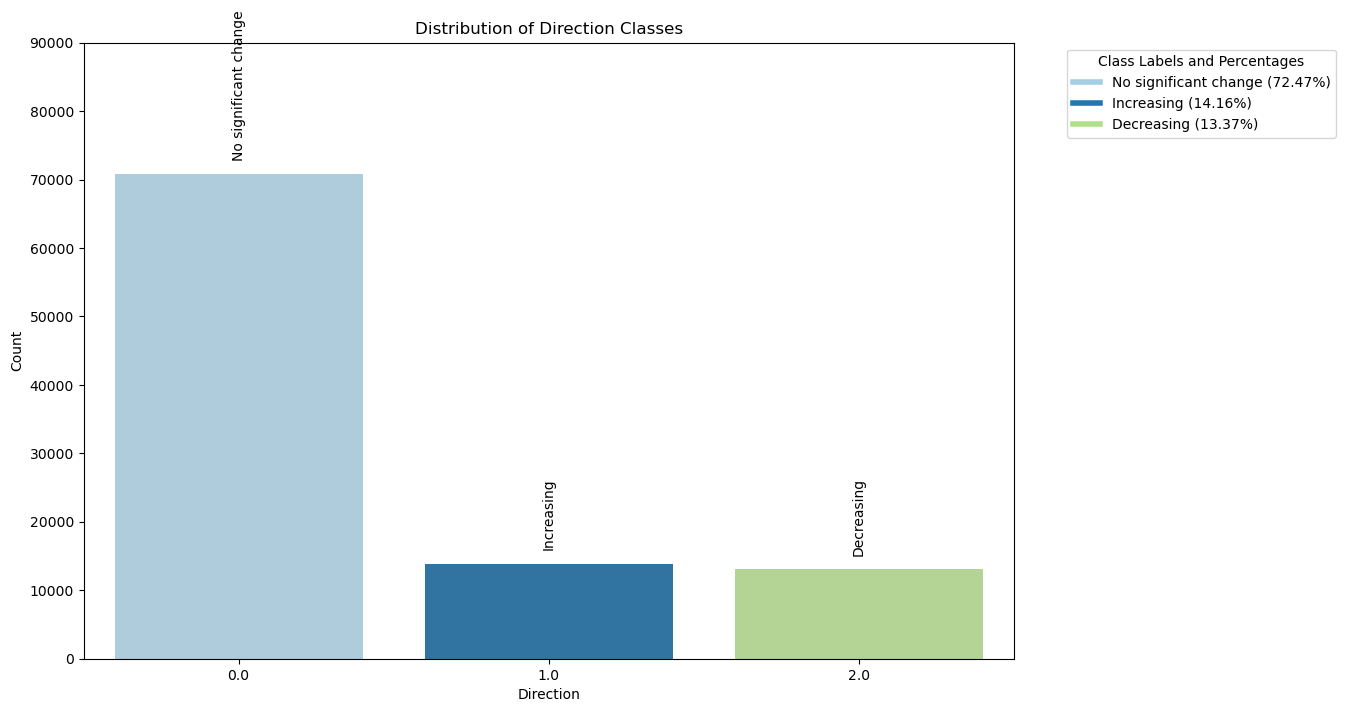

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def create_target_classes(df, column='close', period=60):
    df['Future_Close'] = df[column].shift(-period)  # Look forward 60 minutes
    df['Pct_Change'] = (df['Future_Close'] / df[column]) - 1
    conditions = [
        (df['Pct_Change'] <= -0.005),
        (df['Pct_Change'] > -0.005) & (df['Pct_Change'] <= 0.005),
        (df['Pct_Change'] > 0.005)
    ]
    choices = [2, 0, 1]
    df['Direction'] = np.select(conditions, choices, default=np.nan)
    df = df.drop(columns=['Future_Close', 'Pct_Change'])
    return df.dropna(subset=['Direction'])

# Apply the function to the DataFrame
filtered_df = create_target_classes(filtered_df)

# Calculate the percentages for each class
direction_counts = filtered_df['Direction'].value_counts()
total_counts = direction_counts.sum()
direction_percentages = (direction_counts / total_counts * 100).round(2)

# Plot the distribution of the Direction column
plt.figure(figsize=(12, 8))
sns.countplot(x='Direction', data=filtered_df, hue='Direction', palette='Paired', dodge=False, legend=False)

# Annotate the plot with the class labels
annotations = {
    0: "No significant change",
    1: "Increasing",
    2: "Decreasing"}

for direction, label in annotations.items():
    plt.text(direction, direction_counts[direction] + 2000, label, ha='center', fontsize=10, rotation=90, va='bottom')

plt.title('Distribution of Direction Classes')
plt.xlabel('Direction')
plt.ylabel('Count')
plt.ylim(0, 90000)  # Set the y-axis limit to 90,000

# Create a custom legend with percentages
handles = []
for direction, label in annotations.items():
    handles.append(
        plt.Line2D([0], [0], color=sns.color_palette('Paired')[direction], lw=4, label=f'{label} ({direction_percentages[direction]}%)')
    )

plt.legend(handles=handles, title='Class Labels and Percentages', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


* Above we can see there class weights for the up and down classes is about even while the neutral class makes up the majority of the data, this is expected when dealing with stock pricing.
------------------------

In [6]:
proportions = filtered_df['Direction'].value_counts(normalize=True) * 100

# Print the proportions
print(proportions)

Direction
0.0    72.468620
1.0    14.159346
2.0    13.372033
Name: proportion, dtype: float64


Below are some descriptive statistics for the input variables

In [7]:
input_vars = filtered_df.drop(columns = 'Direction')
htmldf(input_vars.describe())

,close,AD,OBV,TOS_STDEVALL_LR,MSFT,GOOGL,META,WMT,BABA,peak,epeak,valley,evalley,g_peak,m_peak,w_peak,b_peak,ms_peak,g_valley,m_valley,w_valley,b_valley,ms_valley,720w_ratio,A_M_ratio,A_B_ratio,A_G_ratio,A-B,A-MS,close_diff_1,close_diff_2,close_diff_3,close_diff_4,close_diff_5,Close_Discretized
count,97674.000000,9.767400e+04,9.767400e+04,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000,97674.000000
mean,161.664129,1.190788e+06,2.825780e+06,161.582970,387.831465,149.114582,407.377684,117.886154,78.644082,0.233675,0.063251,0.233686,0.063968,0.199797,0.174878,0.133659,0.146805,0.179741,0.200555,0.174263,0.132942,0.146549,0.180376,0.997005,0.403561,2.081551,1.084645,83.020047,-226.167336,0.000252,0.000503,0.000755,0.001010,0.001266,1.500082
std,22.074108,9.396894e+05,1.712583e+06,20.573298,42.101672,18.215281,84.562730,48.609477,6.592588,0.423170,0.243416,0.423177,0.244697,0.399850,0.379864,0.340287,0.353913,0.383973,0.400418,0.379338,0.339514,0.353657,0.384502,0.058194,0.035868,0.387050,0.083054,26.299991,21.999049,0.152185,0.214107,0.262139,0.299656,0.332292,1.118360
min,124.480000,-2.726624e+05,-6.223696e+04,126.087660,312.680000,123.460000,286.360000,58.810000,68.477200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.337901,0.330001,1.420903,0.913658,38.370000,-266.735000,-8.545000,-8.610000,-11.150000,-11.600000,-11.670000,0.000000
25%,141.565000,1.956560e+05,1.236917e+06,143.704843,347.841250,135.250000,319.370000,64.890000,73.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994453,0.369057,1.643240,1.038048,54.636250,-241.410000,-0.050000,-0.070000,-0.090000,-0.100000,-0.115000,0.000000
50%,166.842500,1.598499e+06,3.641042e+06,161.823374,401.210000,141.377500,432.295000,154.770000,76.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.001679,0.401434,2.195341,1.072161,91.052500,-230.545000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,182.010000,2.024507e+06,4.369658e+06,179.584659,420.623750,166.480000,488.930000,161.520000,83.440000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.009280,0.435232,2.390373,1.122605,105.710000,-213.030000,0.050000,0.075000,0.095000,0.110000,0.120000,3.000000
max,199.745000,2.696474e+06,4.857056e+06,196.350906,463.737800,189.530000,530.855600,174.340000,96.192800,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.087927,0.476935,2.768031,1.357559,126.985000,-180.450000,9.700000,9.930000,10.790000,9.400000,9.560000,3.000000


In [8]:
# Calculate class weights
classes = filtered_df['Direction'].unique()
y_train = filtered_df['Direction']
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))

class_weights_dict

{0.0: 0.45996920164446264, 2.0: 2.4927647193936147, 1.0: 2.354157628344179}

In [6]:
def optimize_memory_usage(df):
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    for col in df.select_dtypes(include=['int64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    return df

# Function to create additional features
def create_additional_features(df):
    df['SMA_15'] = df['close'].rolling(window=15).mean()
    df['SMA_60'] = df['close'].rolling(window=60).mean()
    df['Volatility'] = df['close'].rolling(window=60).std()
    df['Lag_1'] = df['close'].shift(1)
    df['Lag_5'] = df['close'].shift(5)
    df['Lag_10'] = df['close'].shift(10)
    df['RSI'] = compute_RSI(df['close'], window=14)  # Implement compute_RSI function
    df = df.dropna()
    return df

def compute_RSI(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

# Function to remove constant features
def remove_constant_features(df):
    constant_features = [col for col in df.columns if df[col].nunique() <= 1]
    return df.drop(columns=constant_features)

def cluster_features(df, n_clusters=10):
    fa = FeatureAgglomeration(n_clusters=n_clusters)
    reduced_features = fa.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_features, index=df.index, columns=[f'cluster_{i}' for i in range(n_clusters)])
    return reduced_df
    
# Function to select top K features
def select_top_k_features(X, y, k=10):
    selector = SelectKBest(f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    return X_new, selected_features

def evaluate_model(y_true_val, y_pred_val, y_true_test=None, y_pred_test=None, model=None, X_val=None, X_test=None):
    # Evaluate on Validation Data
    print("Validation Set Performance:")
    cm_val = confusion_matrix(y_true_val, y_pred_val)
    accuracy_val = accuracy_score(y_true_val, y_pred_val)
    precision_val = precision_score(y_true_val, y_pred_val, average='weighted',zero_division = 0)
    recall_val = recall_score(y_true_val, y_pred_val, average='weighted',zero_division = 0)
    f1_val = f1_score(y_true_val, y_pred_val, average='weighted',zero_division = 0)
    
    print("Confusion Matrix (Validation):")
    print(cm_val)
    print(f"Accuracy: {accuracy_val}")
    print(f"Precision: {precision_val}")
    print(f"Recall: {recall_val}")
    print(f"F1 Score: {f1_val}")
    
    if model is not None and X_val is not None:
        try:
            y_true_val_binarized = label_binarize(y_true_val, classes=np.unique(y_pred_val))
            y_pred_val_prob = model.predict_proba(X_val)
            auc_val = roc_auc_score(y_true_val_binarized, y_pred_val_prob, multi_class='ovr')
            print(f"AUC Score (Validation): {auc_val}")
        except ValueError:
            print("AUC Score (Validation): Not applicable for multi-class with current configuration")
        except AttributeError:
            print("AUC Score (Validation): Model does not support probability prediction")
    else:
        print("AUC Score (Validation): Skipped because the model or validation data was not provided")

    # Plot the heatmap for Validation Data
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(y_true_val), yticklabels=np.unique(y_true_val))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap (Validation)')
    plt.show()
    
    # If Test Data is provided, evaluate on it
    if y_true_test is not None and y_pred_test is not None:
        print("\nTest Set Performance:")
        cm_test = confusion_matrix(y_true_test, y_pred_test)
        accuracy_test = accuracy_score(y_true_test, y_pred_test)
        precision_test = precision_score(y_true_test, y_pred_test, average='weighted')
        recall_test = recall_score(y_true_test, y_pred_test, average='weighted')
        f1_test = f1_score(y_true_test, y_pred_test, average='weighted')
        
        print("Confusion Matrix (Test):")
        print(cm_test)
        print(f"Accuracy: {accuracy_test}")
        print(f"Precision: {precision_test}")
        print(f"Recall: {recall_test}")
        print(f"F1 Score: {f1_test}")
        
        if model is not None and X_test is not None:
            try:
                y_true_test_binarized = label_binarize(y_true_test, classes=np.unique(y_pred_test))
                y_pred_test_prob = model.predict_proba(X_test)
                auc_test = roc_auc_score(y_true_test_binarized, y_pred_test_prob, multi_class='ovr')
                print(f"AUC Score (Test): {auc_test}")
            except ValueError:
                print("AUC Score (Test): Not applicable for multi-class with current configuration")
            except AttributeError:
                print("AUC Score (Test): Model does not support probability prediction")
        else:
            print("AUC Score (Test): Skipped because the model or test data was not provided")

        # Plot the heatmap for Test Data
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm_test, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(y_true_test), yticklabels=np.unique(y_true_test))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix Heatmap (Test)')
        plt.show()

def split_data(df, validation_start, test_start):
    train_df = df[:validation_start]
    validation_df = df[validation_start:test_start]
    test_df = df[test_start:]
    return train_df, validation_df, test_df
# Optimize memory usage by downcasting data types
filtered_df = filtered_df.drop(columns=['timestamp', 'Close_Discretized'])
filtered_df = optimize_memory_usage(filtered_df)

# Create additional features
filtered_df = create_additional_features(filtered_df)

Completed 25% of training
Completed 50% of training
Completed 75% of training
Lookback period: 4320
Validation Set Performance:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     13859
         1.0       0.00      0.00      0.00      2770
         2.0       0.14      1.00      0.24      2600

    accuracy                           0.14     19229
   macro avg       0.05      0.33      0.08     19229
weighted avg       0.02      0.14      0.03     19229

Model training and evaluation complete.
Confusion Matrix:
[[    0     0 13859]
 [    0     0  2770]
 [    0     0  2600]]
Accuracy: 0.1352124395444381
Precision: 0.018282403807558325
Recall: 0.1352124395444381
F1 Score: 0.032209660801277115
AUC Score: Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

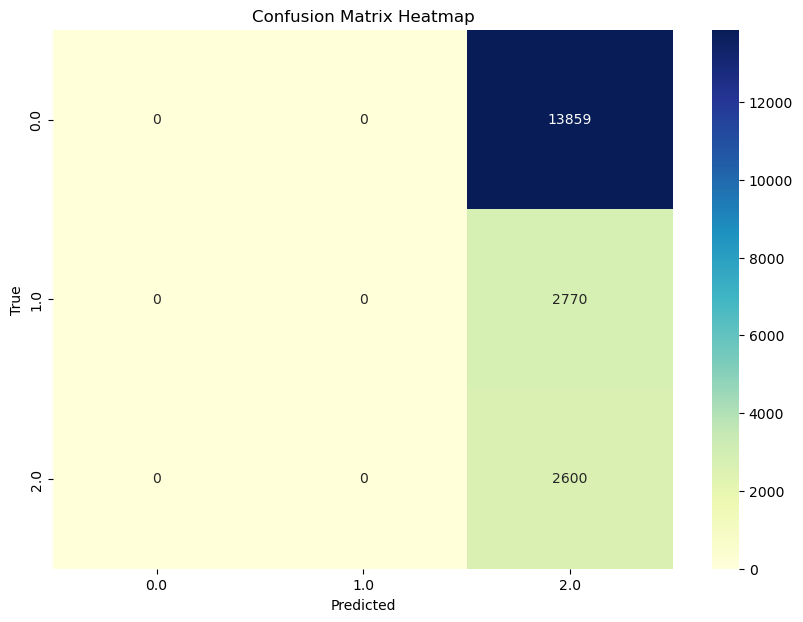

In [10]:
def train_validate_and_evaluate_model(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns

    # Initialize incremental learning model
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights_dict)

    
    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period
    quartiles = [int(total_windows * 0.25), int(total_windows * 0.5), int(total_windows * 0.75)]

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError as e:
            print(f"Error during partial_fit in window {start} to {end}: {e}")
            continue

        if end - lookback_period in quartiles:
            quartile = quartiles.index(end - lookback_period) + 1
            print(f"Completed {quartile * 25}% of training")

    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return y_val.tolist(), []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return y_val.tolist(), []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val


# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model(train_df, validation_df, lookback_period=4320, target_column='Direction')

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)

-----------------------

Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 60.00%
Training progress: 70.00%
Training progress: 80.00%
Training progress: 90.00%
Training progress: 100.00%
Lookback period: 4320
Model training, validation, and testing complete.
Validation Set Performance:
Confusion Matrix (Validation):
[[13859     0     0]
 [ 2770     0     0]
 [ 2600     0     0]]
Accuracy: 0.7207343075562952
Precision: 0.5194579420886524
Recall: 0.7207343075562952
F1 Score: 0.6037631025400566
AUC Score (Validation): Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(


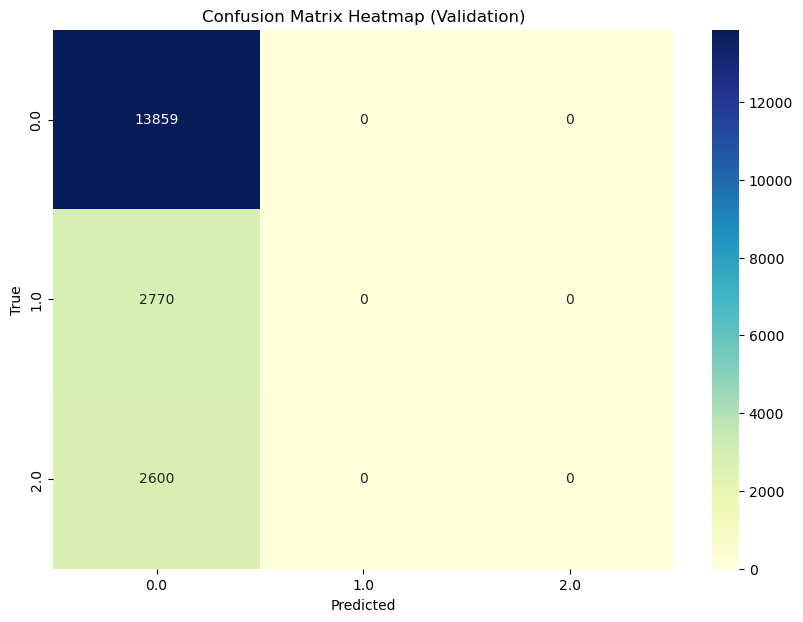

/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SGDClassifier was fitted without feature names
  warnings.warn(



Test Set Performance:
Confusion Matrix (Test):
[[6328    0    0]
 [1494    0    0]
 [1793    0    0]]
Accuracy: 0.6581383255330213
Precision: 0.43314605553540914
Recall: 0.6581383255330213
F1 Score: 0.5224486387722459
AUC Score (Test): Not applicable for multi-class with current configuration


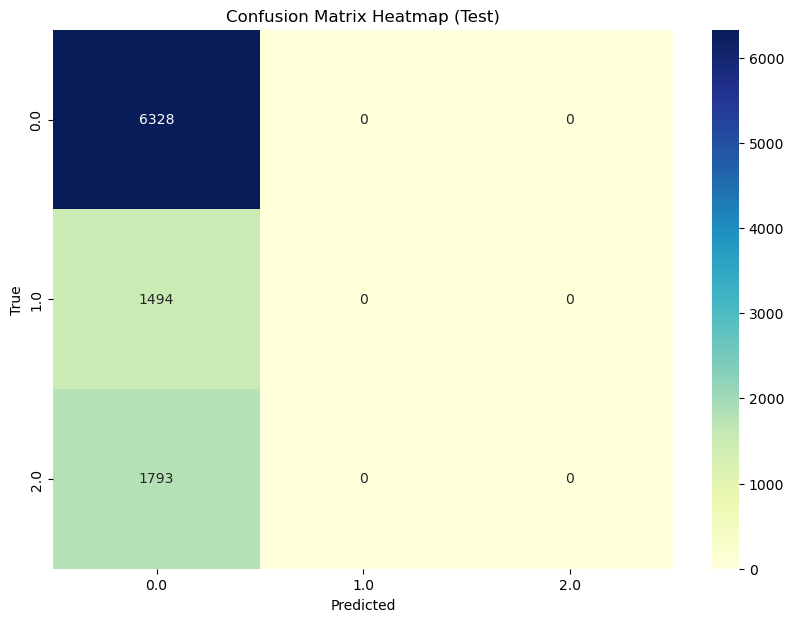

In [11]:
def train_validate_and_evaluate_model_sgd(train_df, validation_df, test_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Initialize SGDClassifier
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights_dict)
    
    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError as e:
            print(f"Error during partial_fit in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return model, feature_selector, y_val.tolist(), [], [], []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return model, feature_selector, y_val.tolist(), [], [], []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return model, feature_selector, y_val.tolist(), [], [], []

    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_sgd(
    train_df, validation_df, test_df, lookback_period=4320, target_column='Direction'
)

# Evaluate the model on both validation and test sets
evaluate_model(y_true_val, y_pred_val, y_true_test=y_true_test, y_pred_test=y_pred_test, model=model, X_val=validation_df.drop(columns=['Direction']), X_test=test_df.drop(columns=['Direction']))


---------------------------------

In [ ]:
def train_validate_and_evaluate_model_sgd(train_df, validation_df, test_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Define steeper class weights
    class_weights_dict = {0.0: 0.45996920164446264, 1.0: 10, 2.0: 10}

    # Initialize SGDClassifier with steeper class weights
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights_dict)
    
    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train, y_train, classes=unique_classes)
        except ValueError as e:
            print(f"Error during partial_fit in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return model, feature_selector, y_val.tolist(), [], [], []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return model, feature_selector, y_val.tolist(), [], [], []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return model, feature_selector, y_val.tolist(), [], [], []

    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_sgd(
    train_df, validation_df, test_df, lookback_period=11700, target_column='Direction'
)

# Evaluate the model on both validation and test sets
evaluate_model(y_true_val, y_pred_val, y_true_test=y_true_test, y_pred_test=y_pred_test, model=model, X_val=validation_df.drop(columns=['Direction']), X_test=test_df.drop(columns=['Direction']))


Training progress: 0.00%


BHBHBHB

Total training windows: 58615
Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 59.99%
Training progress: 69.99%
Training progress: 79.99%
Training progress: 89.99%
Training progress: 99.99%
Validation Set Performance:
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77     13898
         1.0       0.17      0.23      0.20      2622
         2.0       0.63      0.01      0.02      2661

    accuracy                           0.63     19181
   macro avg       0.51      0.36      0.33     19181
weighted avg       0.64      0.63      0.59     19181

Model training and evaluation complete.
Confusion Matrix:
[[11412  2469    17]
 [ 2005   615     2]
 [ 2140   488    33]]
Accuracy: 0.6287471977477712
Precision: 0.6430932127450296
Recall: 0.6287471977477712
F1 Score: 0.5919737976206594
AUC Score: Not applicable for multi-cla

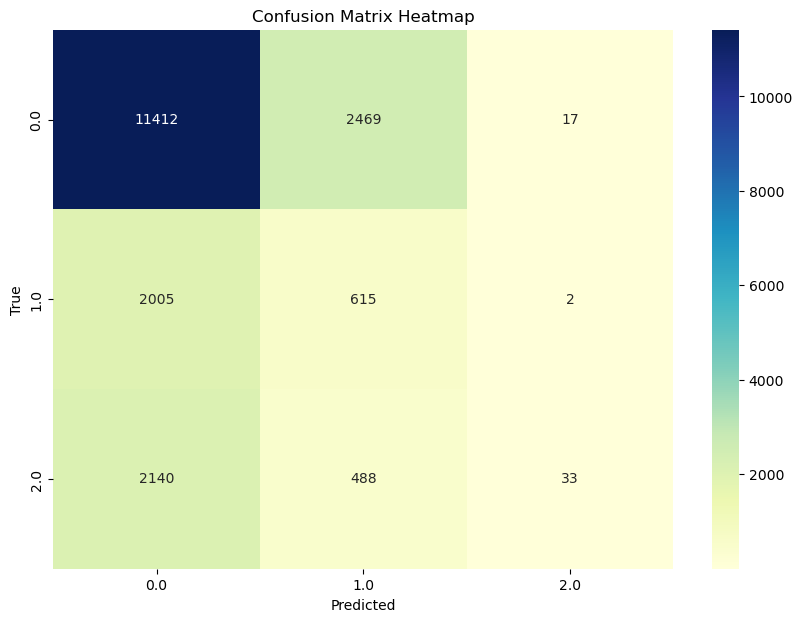

In [14]:
def train_validate_and_evaluate_model_sgd(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Initialize incremental learning model with more balanced class weights
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights_dict)

    unique_classes = train_df[target_column].unique()

    # Scaling and PCA
    scaler = StandardScaler()
    pca = PCA(n_components=10)  # Adjust number of components

    total_windows = len(train_df) - lookback_period
    print(f"Total training windows: {total_windows}")
    
    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        # Convert string columns to object type (optional: before fillna)
        X_train = X_train.convert_dtypes()
        
        # Apply fillna only to numeric columns
        X_train = X_train.fillna(X_train.select_dtypes(include=['number']).mean(numeric_only=True))
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            continue

        X_train_scaled = scaler.fit_transform(X_train)
        X_train_pca = pca.fit_transform(X_train_scaled)

        try:
            model.partial_fit(X_train_pca, y_train, classes=unique_classes)
        except ValueError as e:
            continue

        # Print progress update
        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    # Convert string columns to object type (optional: before fillna)
    X_val = X_val.convert_dtypes()
    
    # Apply fillna only to numeric columns
    X_val = X_val.fillna(X_val.select_dtypes(include=['number']).mean(numeric_only=True))
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        return y_val.tolist(), []

    X_val_scaled = scaler.transform(X_val)
    X_val_pca = pca.transform(X_val_scaled)

    try:
        y_pred_val = model.predict(X_val_pca)
    except NotFittedError as e:
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data using Dask for efficiency
filtered_df_dd = dd.from_pandas(filtered_df, npartitions=10, sort=False)  # Avoid sorting to prevent PyArrow usage
train_df, validation_df, test_df = filtered_df_dd.loc[:validation_start].compute(), filtered_df_dd.loc[validation_start:test_start].compute(), filtered_df_dd.loc[test_start:].compute()

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model_sgd(train_df, validation_df, lookback_period=7800, target_column='Direction')

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)


Total training windows: 58615
Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 59.99%
Training progress: 69.99%
Training progress: 79.99%
Training progress: 89.99%
Training progress: 99.99%
Validation Set Performance:
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79     13898
         1.0       0.19      0.21      0.19      2622
         2.0       0.70      0.01      0.02      2661

    accuracy                           0.65     19181
   macro avg       0.54      0.36      0.33     19181
weighted avg       0.65      0.65      0.60     19181

Model training and evaluation complete.
Confusion Matrix:
[[11908  1981     9]
 [ 2081   539     2]
 [ 2247   388    26]]
Accuracy: 0.6502789218497471
Precision: 0.6542473197754641
Recall: 0.6502789218497471
F1 Score: 0.6019763080565594
AUC Score: Not applicable for multi-cla

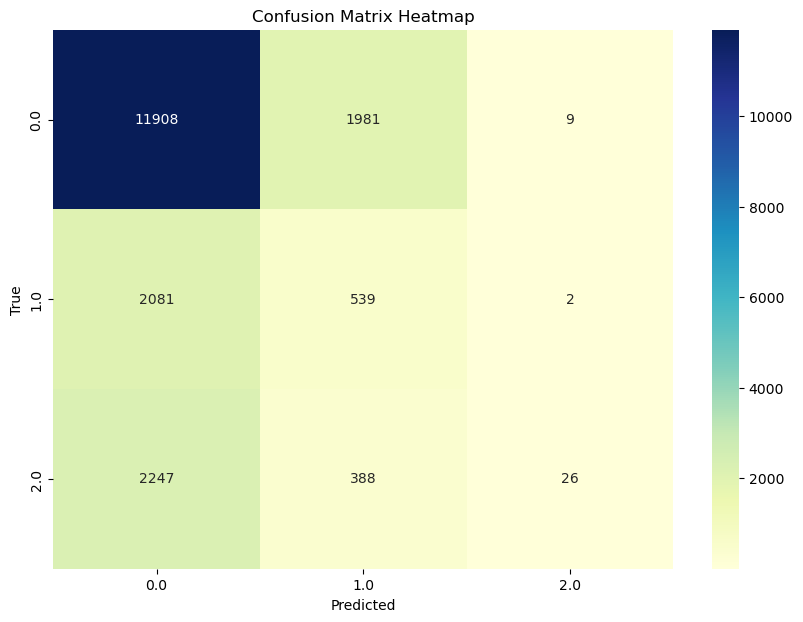

In [15]:
def train_validate_and_evaluate_model_sgd(train_df, validation_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []

    # Initialize incremental learning model with more balanced class weights
    model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, class_weight=class_weights_dict)

    unique_classes = train_df[target_column].unique()

    # Scaling and PCA
    scaler = StandardScaler()
    pca = PCA(n_components=10)  # Adjust number of components

    total_windows = len(train_df) - lookback_period
    print(f"Total training windows: {total_windows}")
    
    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        # Convert string columns to object type (optional: before fillna)
        X_train = X_train.convert_dtypes()
        
        # Apply fillna only to numeric columns
        X_train = X_train.fillna(X_train.select_dtypes(include=['number']).mean(numeric_only=True))
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            continue

        X_train_scaled = scaler.fit_transform(X_train)
        X_train_pca = pca.fit_transform(X_train_scaled)

        try:
            model.partial_fit(X_train_pca, y_train, classes=unique_classes)
        except ValueError as e:
            continue

        # Print progress update
        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    # Convert string columns to object type (optional: before fillna)
    X_val = X_val.convert_dtypes()
    
    # Apply fillna only to numeric columns
    X_val = X_val.fillna(X_val.select_dtypes(include=['number']).mean(numeric_only=True))
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        return y_val.tolist(), []

    X_val_scaled = scaler.transform(X_val)
    X_val_pca = pca.transform(X_val_scaled)

    try:
        y_pred_val = model.predict(X_val_pca)
    except NotFittedError as e:
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    print("Validation Set Performance:")
    print(classification_report(y_true_val, y_pred_val))
    print("Model training and evaluation complete.")

    return y_true_val, y_pred_val

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data using Dask for efficiency
filtered_df_dd = dd.from_pandas(filtered_df, npartitions=10, sort=False)  # Avoid sorting to prevent PyArrow usage
train_df, validation_df, test_df = filtered_df_dd.loc[:validation_start].compute(), filtered_df_dd.loc[validation_start:test_start].compute(), filtered_df_dd.loc[test_start:].compute()

# Train, validate, and evaluate models
y_true_val, y_pred_val = train_validate_and_evaluate_model_sgd(train_df, validation_df, lookback_period=7800, target_column='Direction')

# Evaluate the model on the validation set
evaluate_model(y_true_val, y_pred_val)

# Decision Tree

Training progress: 0.00%
Training progress: 10.00%
Training progress: 20.00%
Training progress: 30.00%
Training progress: 40.00%
Training progress: 50.00%
Training progress: 60.00%
Training progress: 70.00%
Training progress: 80.00%
Training progress: 90.00%
Training progress: 100.00%
Lookback period: 7800
Model training, validation, and testing complete.
Validation Set Performance:
Confusion Matrix (Validation):
[[6744 1270 5845]
 [1500  290  980]
 [1350  185 1065]]
Accuracy: 0.42118674918092464
Precision: 0.5488236872720459
Recall: 0.42118674918092464
F1 Score: 0.46045995915460025
AUC Score (Validation): Not applicable for multi-class with current configuration


/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


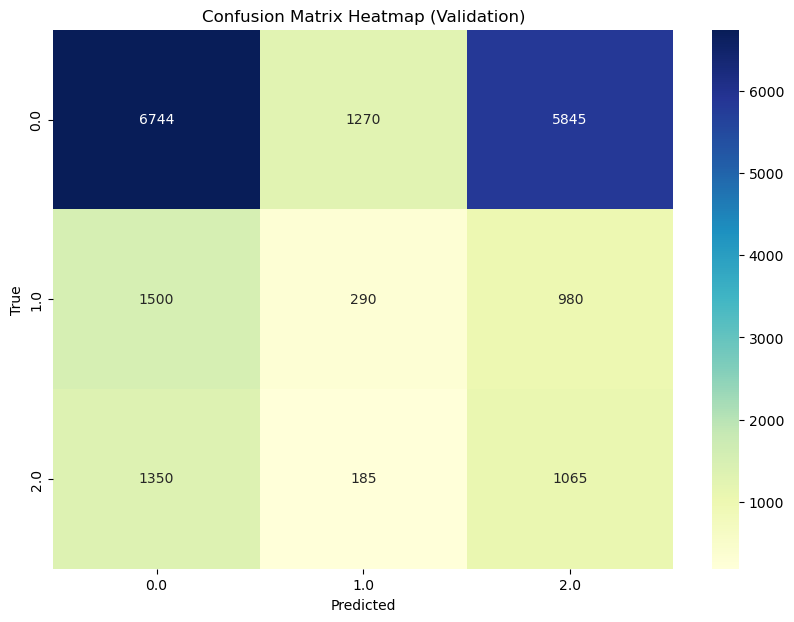

/opt/miniconda3/envs/condaenv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(



Test Set Performance:
Confusion Matrix (Test):
[[3876   20 2432]
 [ 939   88  467]
 [1057   28  708]]
Accuracy: 0.4859074362974519
Precision: 0.5715696479503636
Recall: 0.4859074362974519
F1 Score: 0.48386408991063007
AUC Score (Test): Not applicable for multi-class with current configuration


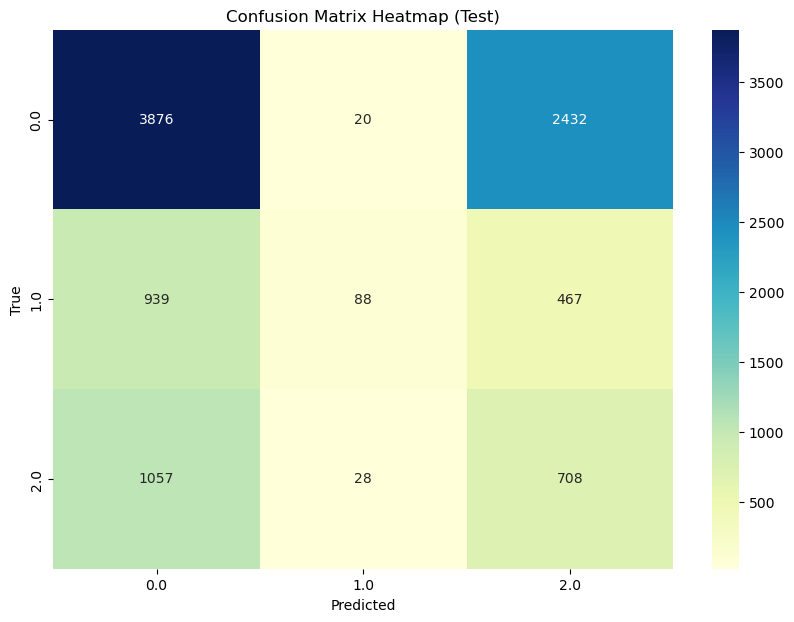

In [10]:
def train_validate_and_evaluate_model_dt(train_df, validation_df, test_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Initialize DecisionTreeClassifier
    model = DecisionTreeClassifier(class_weight=class_weights_dict)

    unique_classes = train_df[target_column].unique()

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.fit(X_train, y_train)
        except ValueError as e:
            print(f"Error during fitting in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return y_val.tolist(), []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return y_val.tolist(), []

    try:
        y_pred_val = model.predict(X_val)
    except NotFittedError as e:
        print(f"Error during prediction: {e}")
        return y_val.tolist(), []

    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_dt(
    train_df, validation_df, test_df, lookback_period=7800, target_column='Direction'
)

# Evaluate the model on both validation and test sets
evaluate_model(y_true_val, y_pred_val, y_true_test=y_true_test, y_pred_test=y_pred_test, model=model, X_val=validation_df.drop(columns=['Direction']), X_test=test_df.drop(columns=['Direction']))


## Minibatch K-means Classifier

In [ ]:
def train_validate_and_evaluate_model_kmeans(train_df, validation_df, test_df, lookback_period, target_column='Direction'):
    y_true_val = []
    y_pred_val = []
    y_true_test = []
    y_pred_test = []

    # Remove constant features from the entire dataset initially
    train_df = remove_constant_features(train_df)
    validation_df = validation_df[train_df.columns]  # Ensure validation set has the same columns
    test_df = test_df[train_df.columns]  # Ensure test set has the same columns

    # Determine the number of unique classes in the target
    unique_classes = train_df[target_column].unique()
    n_clusters = len(unique_classes)

    # Initialize MiniBatchKMeans with the number of clusters equal to the number of unique classes
    model = MiniBatchKMeans(n_clusters=n_clusters, random_state=42)

    feature_selector = None

    total_windows = len(train_df) - lookback_period

    for end in range(lookback_period, len(train_df)):
        start = end - lookback_period
        train_subset = train_df.iloc[start:end]
        
        X_train = train_subset.drop(columns=[target_column])
        y_train = train_subset[target_column]  # This won't be used for fitting, only for comparison

        X_train = X_train.fillna(X_train.mean())
        X_train = remove_constant_features(X_train)

        if X_train.shape[0] == 0:
            print(f"Skipping window from {start} to {end}: Training data is empty.")
            continue

        if X_train.var().sum() == 0:
            print(f"Skipping window from {start} to {end}: Insufficient variance in features.")
            continue

        k_features = min(10, X_train.shape[1])
        if feature_selector is None:
            feature_selector = SelectKBest(f_classif, k=k_features)

        try:
            X_train = feature_selector.fit_transform(X_train, y_train)
        except ValueError as e:
            print(f"Error during feature selection in window {start} to {end}: {e}")
            continue

        try:
            model.partial_fit(X_train)
        except ValueError as e:
            print(f"Error during fitting in window {start} to {end}: {e}")
            continue

        if (end - lookback_period) % (total_windows // 10) == 0:  # Update every 10%
            progress = (end - lookback_period) / total_windows * 100
            print(f"Training progress: {progress:.2f}%")

    # Validation Data
    X_val = validation_df.drop(columns=[target_column])
    y_val = validation_df[target_column]

    X_val = X_val.fillna(X_val.mean())
    X_val = remove_constant_features(X_val)

    if X_val.shape[0] == 0:
        print("Validation failed due to no non-constant features in validation set")
        return model, feature_selector, y_val.tolist(), [], [], []

    if feature_selector:
        X_val = feature_selector.transform(X_val)
    else:
        print("No valid feature selector was trained")
        return model, feature_selector, y_val.tolist(), [], [], []

    try:
        y_pred_val = model.predict(X_val)
    except Exception as e:
        print(f"Error during prediction: {e}")
        return model, feature_selector, y_val.tolist(), [], [], []

    # Map clusters to the most frequent true label
    labels_map = {}
    for cluster in range(n_clusters):
        mask = (y_pred_val == cluster)
        if np.sum(mask) > 0:
            most_common_label = mode(y_val[mask]).mode[0]  # Accessing the mode correctly
            labels_map[cluster] = most_common_label

    y_pred_val = np.array([labels_map[label] for label in y_pred_val])
    y_true_val = y_val.tolist()

    # Test Data
    X_test = test_df.drop(columns=[target_column])
    y_test = test_df[target_column]

    X_test = X_test.fillna(X_test.mean())
    X_test = remove_constant_features(X_test)

    if feature_selector:
        X_test = feature_selector.transform(X_test)

    y_pred_test = model.predict(X_test)

    # Map clusters to the most frequent true label in the test set
    y_pred_test = np.array([labels_map[label] for label in y_pred_test])
    y_true_test = y_test.tolist()

    print(f"Lookback period: {lookback_period}")
    print("Model training, validation, and testing complete.")

    return model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test

# Define your splits
validation_start = int(len(filtered_df) * 0.7)  # 70% training data
test_start = int(len(filtered_df) * 0.9)        # 20% validation data

# Split the data
train_df, validation_df, test_df = split_data(filtered_df, validation_start, test_start)

# Train, validate, and evaluate models
model, feature_selector, y_true_val, y_pred_val, y_true_test, y_pred_test = train_validate_and_evaluate_model_kmeans(
    train_df, validation_df, test_df, lookback_period=7800, target_column='Direction'
)

# Evaluate the model on both validation and test sets
evaluate_model(y_true_val, y_pred_val, y_true_test=y_true_test, y_pred_test=y_pred_test, model=model, X_val=validation_df.drop(columns=['Direction']), X_test=test_df.drop(columns=['Direction']))


Completed 25% of training
Completed 50% of training
Completed 75% of training
Lookback period: 7800
Validation Set Performance:
              precision    recall  f1-score   support

         0.0       0.71      0.47      0.56      9857
         1.0       0.10      0.23      0.14      1732
         2.0       0.12      0.21      0.15      1400

    accuracy                           0.41     12989
   macro avg       0.31      0.30      0.28     12989
weighted avg       0.56      0.41      0.46     12989

Model training and evaluation complete.
Confusion Matrix:
[[4600 3390 1867]
 [1010  392  330]
 [ 908  202  290]]
Accuracy: 0.4066517822773116
Precision: 0.5612537994801062
Recall: 0.4066517822773116
F1 Score: 0.46073132840411657
AUC Score: Not applicable for multi-class with current configuration